# Importer les bibliothèques

In [21]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.cluster import DBSCAN

# Extraction des images (frames) depuis la vidéo

In [22]:
def extraire_frames(video_path, output_dir, frame_format='frame_{:04d}.jpg'):

    os.makedirs(output_dir, exist_ok=True)
    video = cv2.VideoCapture(video_path)

    if not video.isOpened():
        raise IOError("Impossible d'ouvrir la vidéo :(")

    frames = []
    frame_id = 0

    while True:
        success, frame = video.read()

        if not success:
            break

        frames.append(frame)

        frame_path = os.path.join(output_dir, frame_format.format(frame_id))
        cv2.imwrite(frame_path, frame)

        frame_id += 1

    video.release()

    print(f"Extraction terminée : {frame_id} frames extraites")

    return frames, frame_id

In [23]:
frames, frame_id = extraire_frames("/content/corrupted_video.mp4", "/content/Frames")

Extraction terminée : 114 frames extraites


# Afficher quelques frames

In [24]:
def affichage_frames_aleatoirement(output_dir, nb):
    plt.figure(figsize=(10, 10))

    for i, idx in enumerate(random.sample(range(frame_id), nb)):
        frame = cv2.cvtColor(cv2.imread(f"{output_dir}/frame_{idx:04d}.jpg"), cv2.COLOR_BGR2RGB)
        plt.subplot(nb//3, 3, i + 1)
        plt.imshow(frame)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

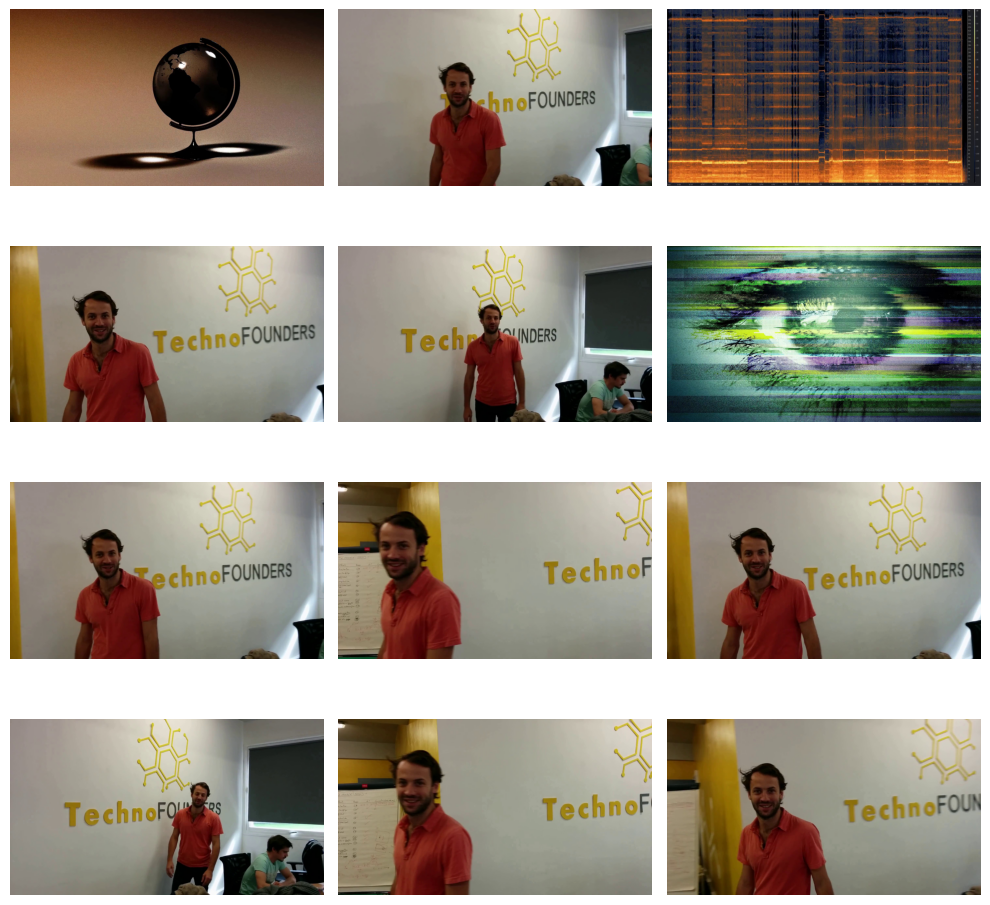

In [25]:
affichage_frames_aleatoirement("/content/Frames", 12)

# Extraire les caractéristiques des frames

### Histogramme couleur - frame normale

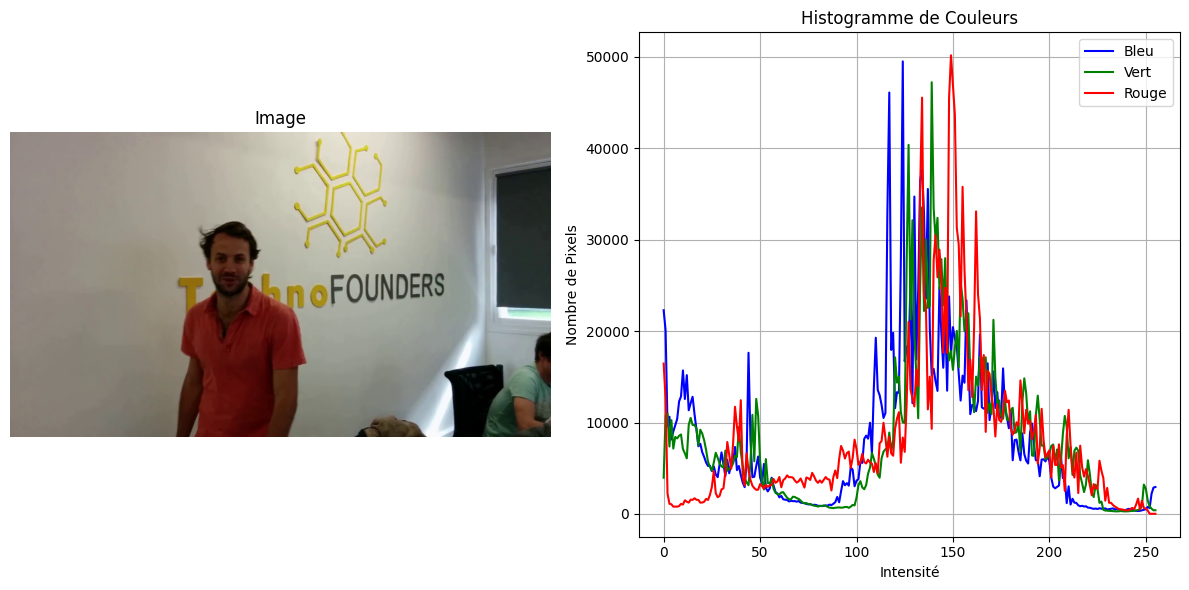

In [26]:
frame = cv2.imread("Frames/frame_0000.jpg")

hist_bleu = cv2.calcHist([frame], [0], None, [256], [0, 256])
hist_vert = cv2.calcHist([frame], [1], None, [256], [0, 256])
hist_rouge = cv2.calcHist([frame], [2], None, [256], [0, 256])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame_rgb)
plt.axis('off')
plt.title("Image")

plt.subplot(1, 2, 2)
plt.plot(hist_bleu, label="Bleu", color="blue")
plt.plot(hist_vert, label="Vert", color="green")
plt.plot(hist_rouge, label="Rouge", color="red")
plt.title("Histogramme de Couleurs")
plt.xlabel("Intensité")
plt.ylabel("Nombre de Pixels")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### Histogramme couleur - frame parasite

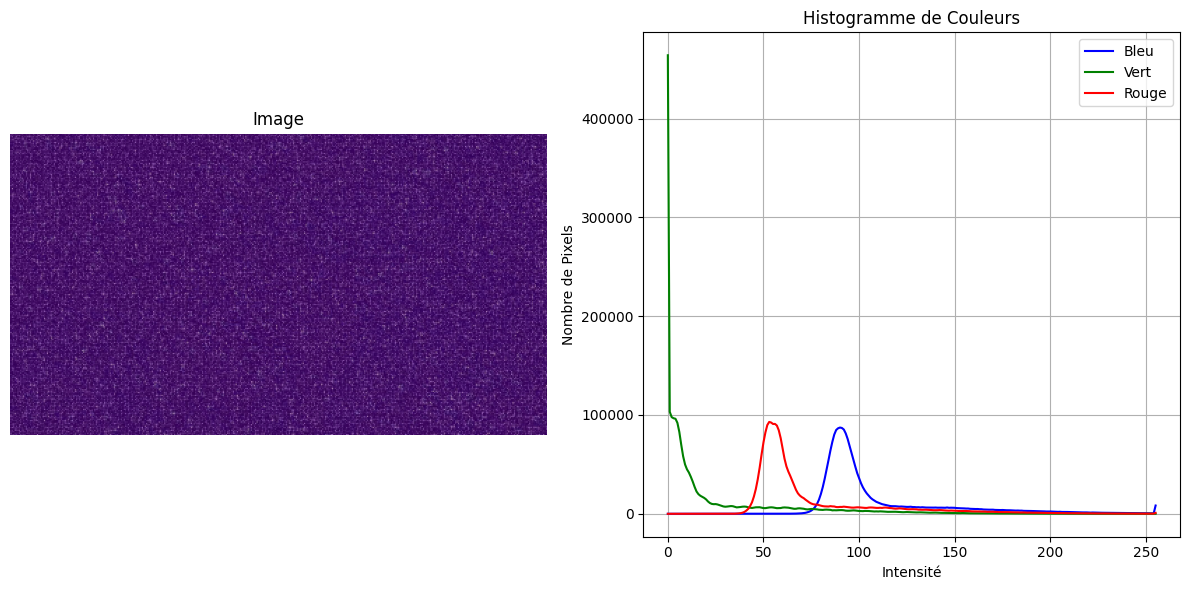

In [27]:
frame = cv2.imread("Frames/frame_0017.jpg")

hist_bleu = cv2.calcHist([frame], [0], None, [256], [0, 256])
hist_vert = cv2.calcHist([frame], [1], None, [256], [0, 256])
hist_rouge = cv2.calcHist([frame], [2], None, [256], [0, 256])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame_rgb)
plt.axis('off')
plt.title("Image")

plt.subplot(1, 2, 2)
plt.plot(hist_bleu, label="Bleu", color="blue")
plt.plot(hist_vert, label="Vert", color="green")
plt.plot(hist_rouge, label="Rouge", color="red")
plt.title("Histogramme de Couleurs")
plt.xlabel("Intensité")
plt.ylabel("Nombre de Pixels")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Extraire les caracteristiques de toutes les frames

In [28]:
def extraire_caracteristiques(frames):

    caracteristiques_frames = []

    sift = cv2.SIFT_create()
    orb = cv2.ORB_create()

    for frame in frames:
        caracteristiques = {}

        frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        hist_bleu = cv2.calcHist([frame], [0], None, [256], [0, 256])
        hist_vert = cv2.calcHist([frame], [1], None, [256], [0, 256])
        hist_rouge = cv2.calcHist([frame], [2], None, [256], [0, 256])
        caracteristiques['hist_bleu'] = cv2.normalize(hist_bleu, hist_bleu).flatten()
        caracteristiques['hist_vert'] = cv2.normalize(hist_vert, hist_vert).flatten()
        caracteristiques['hist_rouge'] = cv2.normalize(hist_rouge, hist_rouge).flatten()

        caracteristiques_frames.append(caracteristiques)

    return caracteristiques_frames

In [29]:
caracteristiques = extraire_caracteristiques(frames)

# Clustering pour detecter les frames parasites (DBSCAN)

## Préparation des données pour DBSCAN

In [30]:
def preparer_donnees_dbscan(caracteristiques):
    donnees = []
    for caract in caracteristiques:
        vecteur = np.hstack([
            caract['hist_bleu'],
            caract['hist_vert'],
            caract['hist_rouge'],
        ])
        donnees.append(vecteur)
    return np.array(donnees)

## DBSCAN

In [31]:
def detecter_frames_parasites(donnees, eps=0.5, min_samples=3):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(donnees)

    labels = clustering.labels_

    indices_normaux = [i for i, label in enumerate(labels) if label != -1]

    indices_parasites = [i for i, label in enumerate(labels) if label == -1]

    return indices_normaux, indices_parasites

## Appliquer DBSCAN pour filtrer les frames parasites

In [32]:
def filtrer_frames_parasites(caracteristiques, frames):
    donnees = preparer_donnees_dbscan(caracteristiques)

    indices_normaux, indices_parasites = detecter_frames_parasites(donnees)

    frames_normales = [frames[i] for i in indices_normaux]

    return frames_normales, indices_normaux, indices_parasites

In [33]:
frames_normales, indices_normaux, indices_parasites = filtrer_frames_parasites(caracteristiques, frames)

## Affichage des frames parasites dans la video

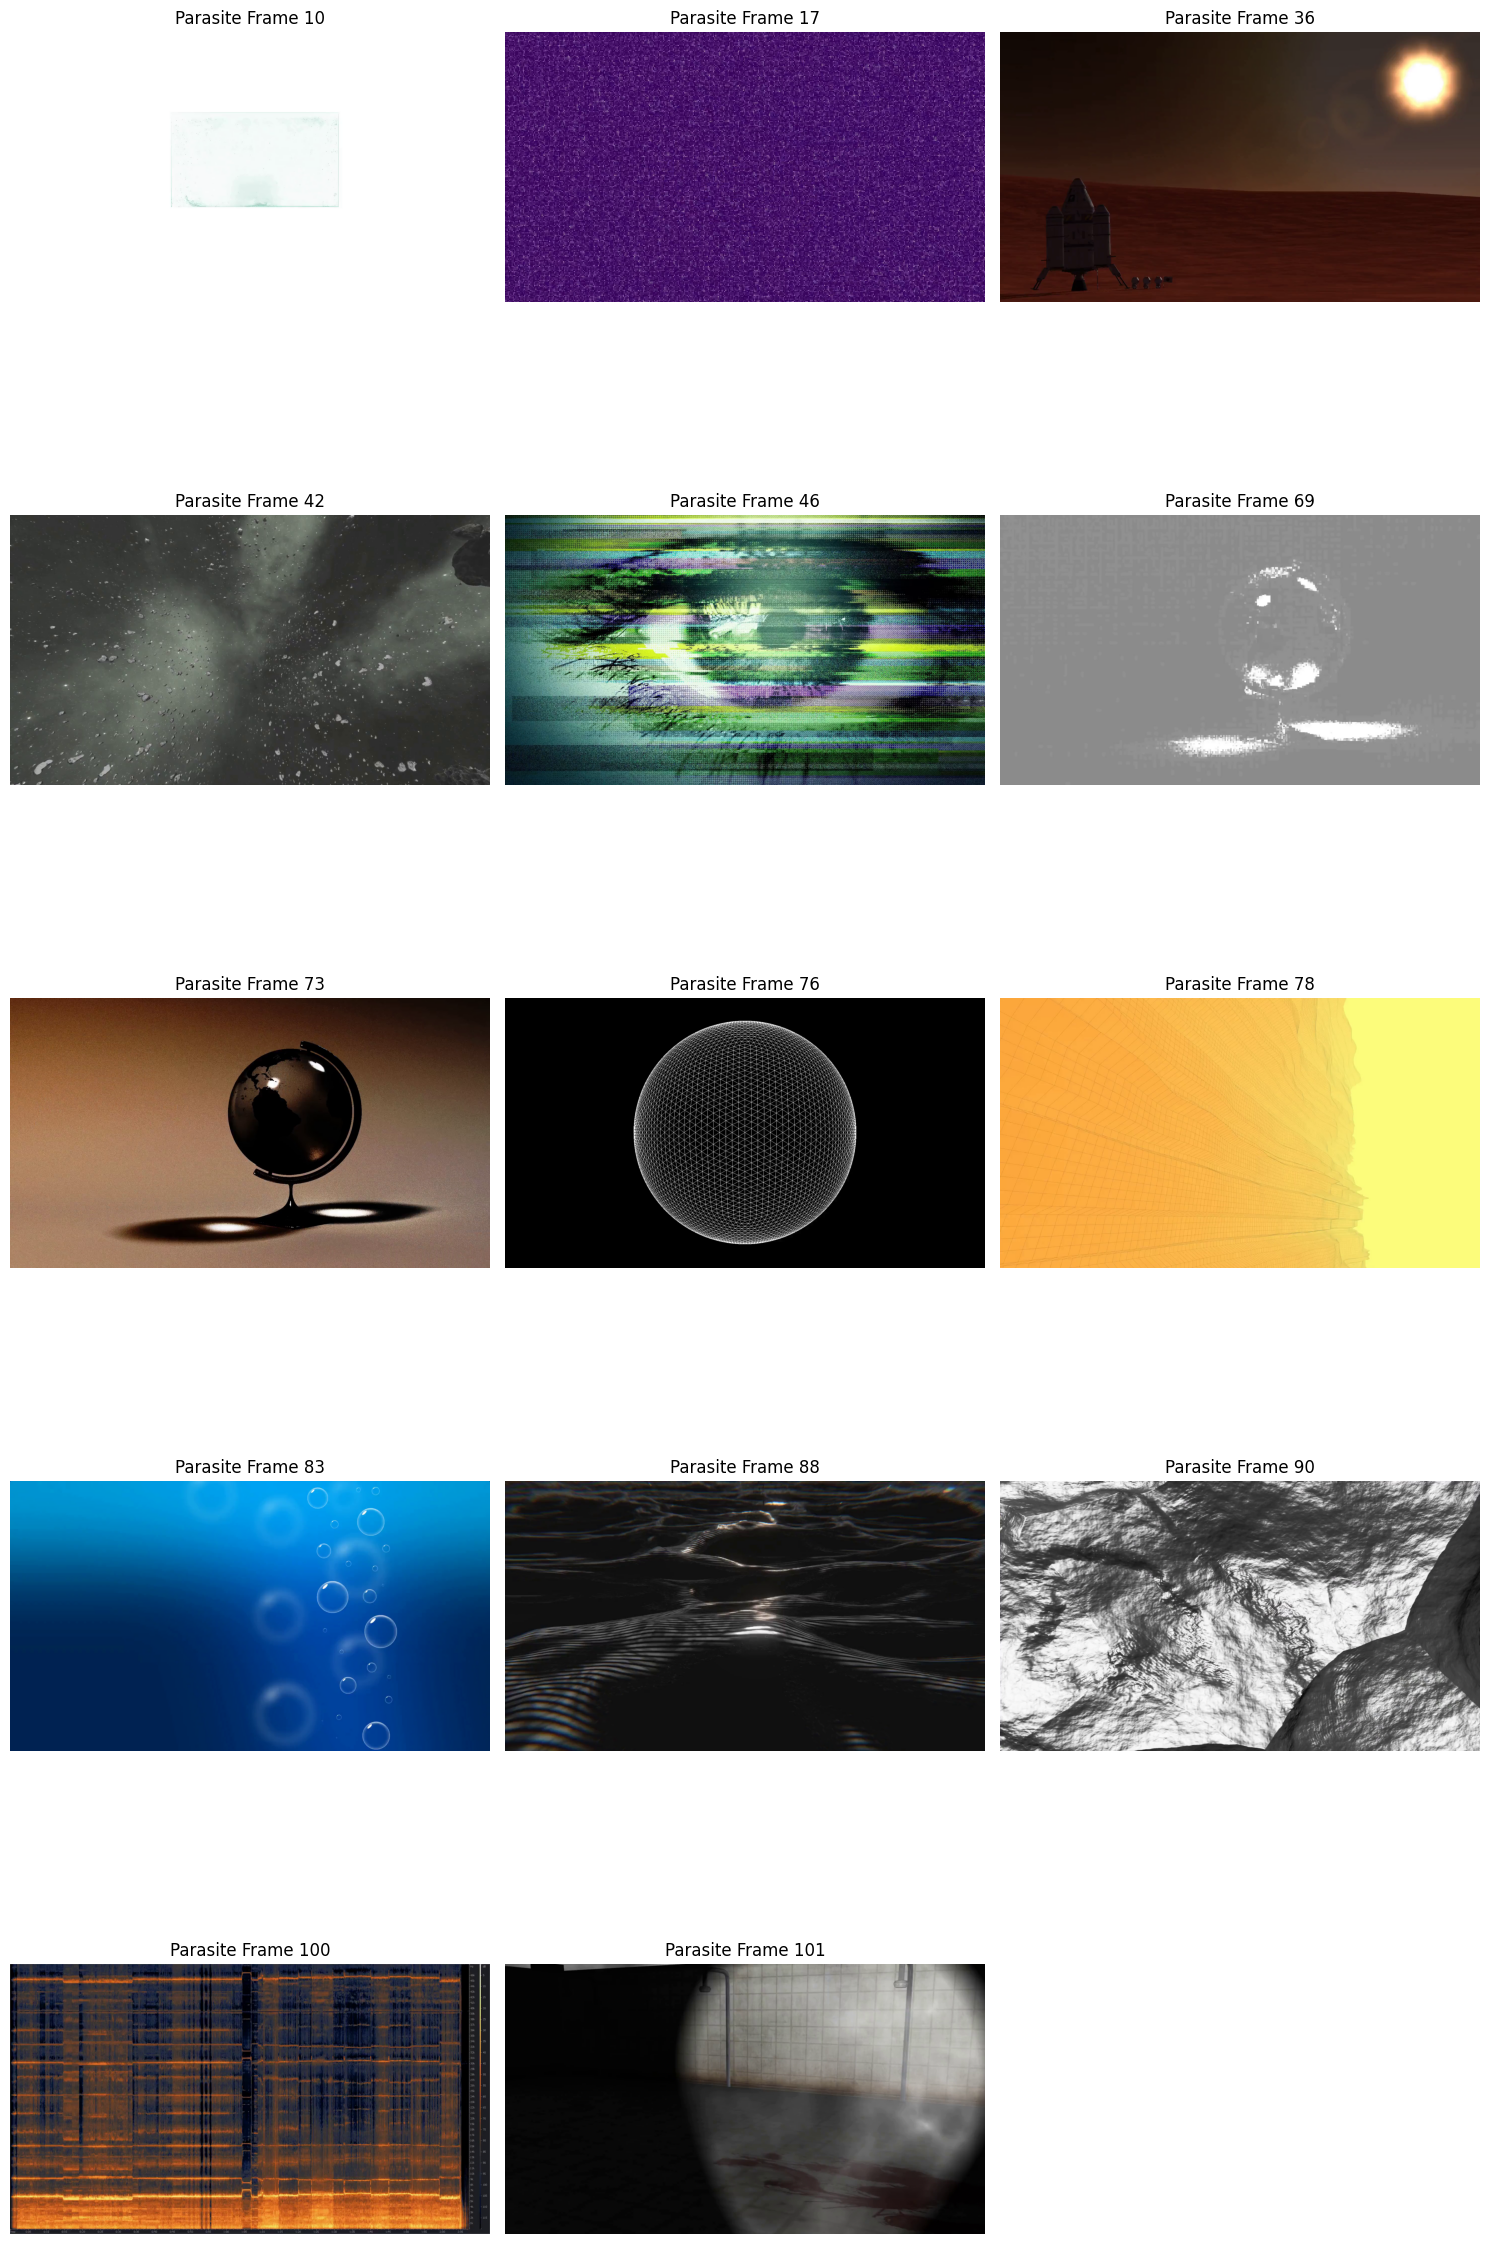

In [34]:
num_frames = len(indices_parasites)
cols = 3
rows = (num_frames + cols - 1) // cols
plt.figure(figsize=(15, rows * 5))
for i, idx in enumerate(indices_parasites):
    frame = frames[idx]
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.title(f"Parasite Frame {idx}")

plt.tight_layout()
plt.show()

# Ordonner les frames

## Calculer la similarité entre deux frames (ORB)

In [35]:
def calculer_similarite(frame1, frame2):
    orb = cv2.ORB_create()
    kp1_orb, des1_orb = orb.detectAndCompute(frame1, None)
    kp2_orb, des2_orb = orb.detectAndCompute(frame2, None)

    score_orb = 0
    if des1_orb is not None and des2_orb is not None:
        bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches_orb = bf_orb.match(des1_orb, des2_orb)
        score_orb = len(matches_orb)

    hist1 = cv2.calcHist([frame1], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist2 = cv2.calcHist([frame2], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    score_hist = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)

    score_total = score_orb + (10 * score_hist)

    return score_total

## Matrice de similarité pour toutes les frames

In [36]:
def construire_matrice_similarite(frames):
    n = len(frames)
    matrice = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            similarite = calculer_similarite(frames[i], frames[j])
            matrice[i, j] = similarite
            matrice[j, i] = similarite

    return matrice

## trouver l'ordre des frames

In [37]:
def trouver_ordre_frames(matrice, frame_depart):
    n = len(matrice)
    visited = set()
    sequence = [frame_depart]
    visited.add(0)

    while len(sequence) < n:
        dernier = sequence[-1]
        prochain = np.argmax([matrice[dernier, k] if k not in visited else -1 for k in range(n)])
        sequence.append(prochain)
        visited.add(prochain)

    return sequence

## Ordonner les frames normales

In [38]:
def ordonner_frames_normales(frames_normales, frame_depart):
    matrice = construire_matrice_similarite(frames_normales)
    ordre = trouver_ordre_frames(matrice, frame_depart)
    return [frames_normales[i] for i in ordre]

In [39]:
frames_ordonnees = ordonner_frames_normales(frames_normales, 1)

# Générer une vidéo depuis les frames ordonnées

In [40]:
def generer_video(frames_ordonnees, output_dir, fps=30, file_name="video_ordonnees.mp4"):
    output_path = os.path.join(output_dir, file_name)

    height, width, channels = frames_ordonnees[0].shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames_ordonnees:
        writer.write(frame)

    writer.release()
    print(f"Vidéo générée et enregistrée sous : {output_path}")

In [41]:
generer_video(frames_ordonnees, "/content/")

Vidéo générée et enregistrée sous : /content/video_ordonnees.mp4


# Fonction finale

In [42]:
def reordonner_video(video_path, output_dir, output_dir_frames, frame_depart):
  frames, frame_id = extraire_frames(video_path, output_dir_frames)
  caracteristiques = extraire_caracteristiques(frames)
  frames_normales, indices_normaux, indices_parasites = filtrer_frames_parasites(caracteristiques, frames)
  frames_ordonnees = ordonner_frames_normales(frames_normales, frame_depart)
  generer_video(frames_ordonnees, output_dir)